### Import modules

In [74]:
import pandas as pd
import json

import datetime
import time
import numpy as np

from imblearn import under_sampling, over_sampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids, TomekLinks, OneSidedSelection, RandomUnderSampler


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, plot_roc_curve, roc_curve, auc

import seaborn as sns
import scikitplot as skplt
from matplotlib import pyplot as plt

### Loading dataset into dataframe

In [75]:
list_transactions = []
with open('transactions.txt') as fp:
    for line in fp:
        list_transactions.append(json.loads(line))

df = pd.DataFrame(list_transactions)

### Structure of the data

There are **786,363** records and **29** fields in the dataset.

In [39]:
#number of records and fields in the dataframe
df.shape

(786363, 29)

Lets take a look at the fields of the dataset.

In [41]:
list(df.columns)

['accountNumber',
 'accountOpenDate',
 'acqCountry',
 'availableMoney',
 'cardCVV',
 'cardLast4Digits',
 'cardPresent',
 'creditLimit',
 'currentBalance',
 'currentExpDate',
 'customerId',
 'dateOfLastAddressChange',
 'echoBuffer',
 'enteredCVV',
 'expirationDateKeyInMatch',
 'isFraud',
 'merchantCategoryCode',
 'merchantCity',
 'merchantCountryCode',
 'merchantName',
 'merchantState',
 'merchantZip',
 'posConditionCode',
 'posEntryMode',
 'posOnPremises',
 'recurringAuthInd',
 'transactionAmount',
 'transactionDateTime',
 'transactionType']

In [154]:
df.groupby('isFraud').mean()

,availableMoney,cardPresent,currentBalance,expirationDateKeyInMatch,transactionAmount,CVVmatched,accountAge,addressAge,isMerchantCountryCode,isPosEntryMode,isTransactionType
isFraud,,,,,,,,,,,
False,6252.455386,0.451469,4502.428675,0.001331,135.570249,0.991198,7.642549e+07,3.881943e+07,0.999170,0.995109,0.999116
True,6142.894186,0.278248,4902.064338,0.001047,225.215905,0.983651,7.357378e+07,3.609041e+07,0.993396,0.978336,0.998873


### Summary statistics
Lets see a quick statistic summary of the data

In [224]:
df.describe()

,availableMoney,currentBalance,transactionAmount,accountAge
count,786363.000000,786363.000000,786363.000000,7.863630e+05
mean,6250.725369,4508.739089,136.985791,7.638046e+07
std,8880.783989,6457.442068,147.725569,6.026442e+07
min,-1005.630000,0.000000,0.000000,1.003300e+05
25%,1077.420000,689.910000,33.650000,3.717734e+07
50%,3184.860000,2451.760000,87.900000,5.878092e+07
75%,7500.000000,5291.095000,191.480000,9.580951e+07
max,50000.000000,47498.810000,2011.540000,8.631763e+08


Now list the unique values for each field in the dataframe as **(fieldname, number of unique values, unique values)**

In [45]:
for col in df:
    if col not in ['cardCVV', 'currentExpDate', 'enteredCVV']:
        print((col, df[col].nunique(), df[col].unique()))
        print()

('accountNumber', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('accountOpenDate', 1820, array(['2015-03-14', '2015-08-06', '2015-10-13', ..., '2009-08-17',
       '2008-04-15', '2012-08-23'], dtype=object))

('acqCountry', 5, array(['US', '', 'CAN', 'MEX', 'PR'], dtype=object))

('availableMoney', 521916, array([ 5000.  ,  4990.63,  4959.25, ..., 48766.15, 48716.72, 48666.83]))

('cardLast4Digits', 5246, array(['1803', '767', '3143', ..., '4635', '3783', '3388'], dtype=object))

('cardPresent', 2, array([False,  True]))

('creditLimit', 10, array([ 5000.,  2500., 50000., 15000., 10000.,   250.,   500.,  1000.,
        7500., 20000.]))

('currentBalance', 487318, array([   0.  ,    9.37,   40.75, ..., 1095.04, 1214.96, 1233.85]))

('customerId', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('dateOfLastAddressChange', 2184, array(['2015-03

Lets now count **null/empty values** for each of remaining fields.

In [10]:
for col in df:
    if df[col].dtype == 'object' and df[df[col] == ''].shape[0] > 0: #fields where data type is string
        print(col, df[df[col] == ''].shape[0])
    elif df[col].isna().sum() > 0:
        print(col, df[col].isna().sum())

acqCountry 4562
echoBuffer 786363
merchantCity 786363
merchantCountryCode 724
merchantState 786363
merchantZip 786363
posConditionCode 409
posEntryMode 4054
posOnPremises 786363
recurringAuthInd 786363
transactionType 698


### Histogram of the Processed Amounts of Each Transaction

The distribution of processed amounts of transactions is **right skewed**, that means it is not symmetric around the mean. The mean is greater than the median. Also notice that the tail of the distribution on the right hand (positive) side is longer than on the left hand side.

My hypothesis is customers use credit card mostly for small transactions.

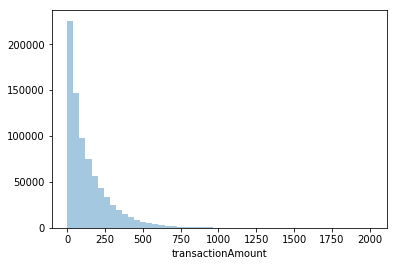

In [11]:
sns.distplot(df['transactionAmount'], hist = True, kde = False)
plt.show()

### Duplicate Transactions

First find the total count of duplicates that resulted from **reversed transactions**.

In [12]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]
dfPurchase = dfUniqueTransaction[df['transactionType'] == 'PURCHASE']
dfReversal = dfUniqueTransaction[df['transactionType'] == 'REVERSAL']

totalReversedDuplicates = 0
totalReversedDuplicatesAmount = 0

dfPurchaseSameAccount = None
prevAccountNumber = None

for _, row in dfReversal.iterrows():
    if row['accountNumber'] != prevAccountNumber:
        dfPurchaseSameAccount = dfPurchase[dfPurchase['accountNumber'] == row['accountNumber']]
        prevAccountNumber = row['accountNumber']
    if ((dfPurchaseSameAccount['transactionAmount'] == row['transactionAmount']) & (dfPurchaseSameAccount['merchantName'] == row['merchantName']) & (row['transactionDateTime'] > dfPurchaseSameAccount['transactionDateTime'])).any():
        totalReversedDuplicates += 1
        totalReversedDuplicatesAmount += row['transactionAmount']

print('Total number of reversal duplicates: ', totalReversedDuplicates)
print('Total dollar amount of reversal duplicates: $', totalReversedDuplicatesAmount)

Total number of reversal duplicates:  17759
Total dollar amount of reversal duplicates: $ 2666519.26999999


Now we will find total count of duplicates that resulted from **multiple swipes**.

In [13]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]
dfPurchase = dfUniqueTransaction[dfUniqueTransaction['transactionType'] == 'PURCHASE']
dfPurchase =dfPurchase.reset_index(drop=True)

totalMultiSwipeDuplicates = 0
totalMultiSwipeDuplicatesAmount = 0

lastSeenDuplicateTransaction = -1

for index1, row in dfPurchase.iterrows():
        
    if index1 < lastSeenDuplicateTransaction:
        continue
        
    for index2 in range(index1+1, dfPurchase.shape[0]):
        if row['accountNumber'] != dfPurchase.iloc[index2]['accountNumber']:
            break
        t1 = pd.to_datetime(row['transactionDateTime'])
        t2 = pd.to_datetime(dfPurchase.iloc[index2]['transactionDateTime'])
        
        
        if pd.Timedelta(t2 - t1).seconds > 300:
            break
                       
        if (row['merchantName'] == dfPurchase.iloc[index2]['merchantName']) and (row['transactionAmount'] == dfPurchase.iloc[index2]['transactionAmount']):
            totalMultiSwipeDuplicates += 1
            totalMultiSwipeDuplicatesAmount += row['transactionAmount']
            lastSeenDuplicateTransaction = index2    

print('Total number of multiple swipes duplicates: ', totalMultiSwipeDuplicates)
print('Total dollar amount of multiple swipes duplicates: $', totalMultiSwipeDuplicatesAmount)

Total number of multiple swipes duplicates:  7463
Total dollar amount of multiple swipes duplicates: $ 1103262.1899999934


Some interesting observation about the duplicate transactions:

* Five fields in the dataset were particularly important to identify both types of duplicate transactions
    * accountNumber
    * merchantName
    * transactionType
    * transactionAmount
    * transactionDateTime
    
    
* Mean value of the amount of both types of duplicate is nearly the same as mean value of total transaction amount. I can intuitively say that the duplicates do not form a distribution that is significantly different from the overall distribution of  transactions.

## Predictive Model

### Data preprocessing

Lets find the fields that has constant (same) values in all rows.

In [76]:
nunique = df.apply(pd.Series.nunique)
constantColumnNames = nunique[nunique == 1].index
constantColumnNames

Index(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip',
       'posOnPremises', 'recurringAuthInd'],
      dtype='object')

Now drop these fields from the dataframe.

In [77]:
df.drop(columns=constantColumnNames, axis=1, inplace=True)

If there are fields that are duplicates (another column exists with same value for each row), we should remove one of the duplicate columns. Below we found that **customerId** is a duplicate field.

In [78]:
duplicateColumnNames = set()
# Iterate over all the columns in dataframe
for x in range(df.shape[1]):
    # Select column at xth index.
    col = df.iloc[:, x]
    # Iterate over all the columns in DataFrame from (x+1)th index till end
    for y in range(x + 1, df.shape[1]):
        # Select column at yth index.
        otherCol = df.iloc[:, y]
        # Check if two columns at x 7 y index are equal
        if col.equals(otherCol):
            duplicateColumnNames.add(df.columns.values[y])
duplicateColumnNames = list(duplicateColumnNames)
duplicateColumnNames

['customerId']

Lets drop **customerId** field

In [79]:
df.drop(columns=duplicateColumnNames, axis=1, inplace=True)

Adding a new field **CVVmatched** that shows if entered CVV matched with original CVV

In [80]:
df['CVVmatched'] = df['enteredCVV'] == df['cardCVV']

Adding a new field **accountAge** that shows how long ago (in seconds) the account was opened until the transaction

In [81]:
df['accountAge'] = pd.to_datetime(df['transactionDateTime']) - pd.to_datetime(df['accountOpenDate'])
df['accountAge'] = df['accountAge'].dt.total_seconds()

Adding a new field **addressAge** that shows what how long (in seconds) the cardholder has been living in his last address until the transaction 

In [82]:
df['addressAge'] = pd.to_datetime(df['transactionDateTime']) - pd.to_datetime(df['dateOfLastAddressChange'])
df['addressAge'] = df['addressAge'].dt.total_seconds()

Adding new column **isMerchantCountryCode**

In [83]:
def label_race (row):
    if row['merchantCountryCode'] == '' :
        return False
    else:
        return True
#df.apply (lambda row: label_race(row), axis=1)
df['isMerchantCountryCode'] = df.apply (lambda row: label_race(row), axis=1)

In [84]:
def label_race (row):
    if row['posConditionCode'] == '' :
        return False
    else:
        return True
#df.apply (lambda row: label_race(row), axis=1)
df['isPosConditionCode'] = df.apply (lambda row: label_race(row), axis=1)

In [85]:
def label_race (row):
    if row['posEntryMode'] == '' :
        return False
    else:
        return True
#df.apply (lambda row: label_race(row), axis=1)
df['isPosEntryMode'] = df.apply (lambda row: label_race(row), axis=1)

In [86]:
def label_race (row):
    if row['merchantCategoryCode'] in ['rideshare', 'online_retail', 'online_gifts', 'airline']:
        return 'High'
#     elif row['merchantCategoryCode'] in ['entertainment', 'fastfood', 'auto', 'food', 'furniture', 'subscriptions']:
#         return 'Medium'
    else:
        return 'Low'
#df.apply (lambda row: label_race(row), axis=1)
df['merchantCategoryRisk'] = df.apply (lambda row: label_race(row), axis=1)

In [87]:
def label_race (row):
    if row['transactionType'] == 'ADDRESS_VERIFICATION' :
        return False
    else:
        return True
#df.apply (lambda row: label_race(row), axis=1)
df['isTransactionType'] = df.apply (lambda row: label_race(row), axis=1)

### Feature Selection

From the correlation matrix below we see **creditLimit** and **availableMoney** are highly correlated.

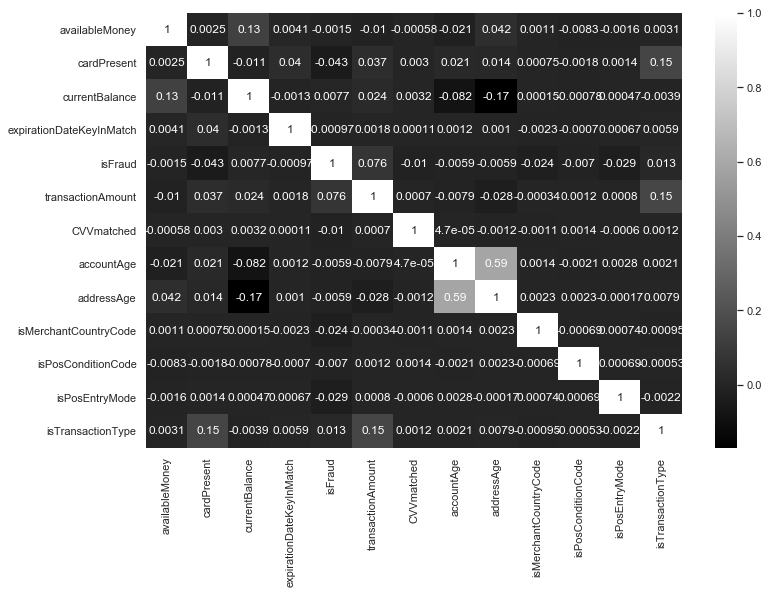

In [119]:
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="gist_gray")
plt.show()

Features **creditLimit** and **availableMoney** are highly correlated (ρ = 0.834977). I will drop **creditLimit**.

In [89]:
df.drop(columns=['creditLimit'], axis=1, inplace=True)

For transactions with empty ('') **merchantCountryCode** value , below we see there is a higher ratio for a them being fraud.

Now lets remove unimportant categorical fields.

In [90]:
df.drop(columns=['currentExpDate','merchantName', 'accountOpenDate',  'cardLast4Digits',  'dateOfLastAddressChange', 'transactionDateTime', 'accountNumber', 'cardCVV', 'enteredCVV'], axis=1, inplace=True)

C:\Users\mxs7435xx\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


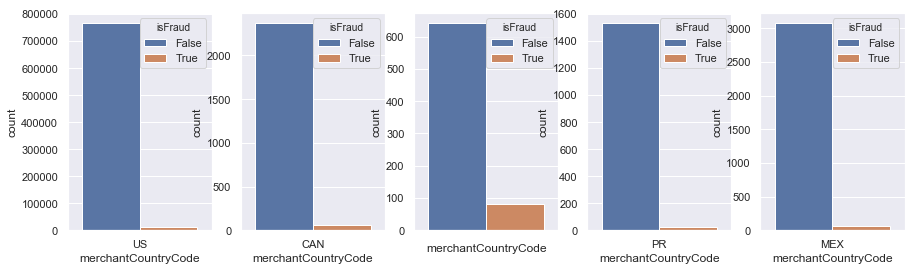

In [91]:
fig, ax = plt.subplots(1, 5)
sns.set(rc={'figure.figsize':(15, 4)})

for index, value in enumerate(df['merchantCountryCode'].unique()):
    sns.countplot(x='merchantCountryCode', hue='isFraud', data=df[df['merchantCountryCode']== value], ax=ax[index])
fig.show()

C:\Users\mxs7435xx\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


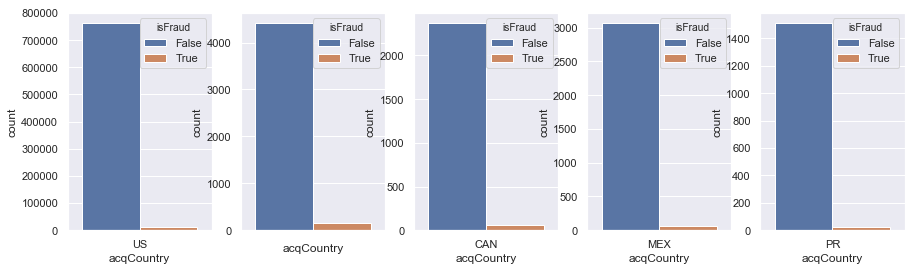

In [92]:
col = 'acqCountry'

fig, ax = plt.subplots(1, df[col].nunique())
sns.set(rc={'figure.figsize':(15, 4)})

for index, value in enumerate(df[col].unique()):
    sns.countplot(x=col, hue='isFraud', data=df[df[col]== value], ax=ax[index])
fig.show()

In [93]:
print(df.columns)

Index(['acqCountry', 'availableMoney', 'cardPresent', 'currentBalance',
       'expirationDateKeyInMatch', 'isFraud', 'merchantCategoryCode',
       'merchantCountryCode', 'posConditionCode', 'posEntryMode',
       'transactionAmount', 'transactionType', 'CVVmatched', 'accountAge',
       'addressAge', 'isMerchantCountryCode', 'isPosConditionCode',
       'isPosEntryMode', 'merchantCategoryRisk', 'isTransactionType'],
      dtype='object')


In [94]:
df_temp = df
dum_df = pd.get_dummies(df_temp, columns=[ 'merchantCategoryRisk'])
df_temp = dum_df

In [95]:
y = df_temp[['isFraud']]
X = df_temp.drop(columns=['acqCountry','transactionType', 'posConditionCode', 'merchantCountryCode',  'isFraud', 'posEntryMode' , 'merchantCategoryCode'], axis=1)

X.columns

Index(['availableMoney', 'cardPresent', 'currentBalance',
       'expirationDateKeyInMatch', 'transactionAmount', 'CVVmatched',
       'accountAge', 'addressAge', 'isMerchantCountryCode',
       'isPosConditionCode', 'isPosEntryMode', 'isTransactionType',
       'acqCountry_', 'acqCountry_CAN', 'acqCountry_MEX', 'acqCountry_PR',
       'acqCountry_US', 'merchantCategoryRisk_High',
       'merchantCategoryRisk_Low'],
      dtype='object')

### Re-sampling

I will now check if the dataset is balanaced. From the plot below it's clear that the dataset is **highly imbalanced**.

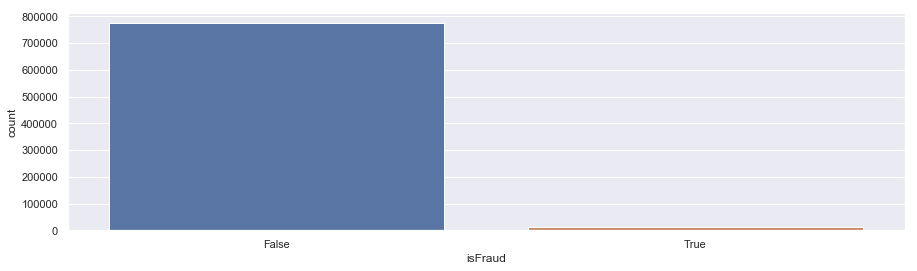

In [96]:
sns.countplot(x='isFraud', data = df)
plt.show()

Lets first split the dataset into training and testing set.

In [97]:
scaled_features = StandardScaler().fit_transform(X.values)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will now re-sample the dataset to get a balanced training data.

In [98]:
# define pipeline
over = SMOTE(sampling_strategy=1)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
#X, y = pipeline.fit_resample(X, y)
X_train, y_train = pipeline.fit_resample(X_train, y_train)

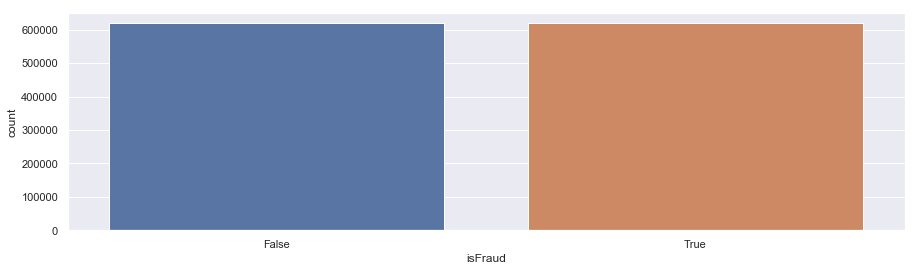

In [99]:
sns.countplot(x='isFraud', data = X_train.join(y_train))

In [100]:
# from sklearn.feature_selection import RFE
# logreg = LogisticRegression(max_iter=1000)
# rfe = RFE(logreg, 15)
# rfe = rfe.fit(X_train, y_train.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)

In [101]:
# dfBool = pd.Series(rfe.support_)

# X_train = X_train[X_train.columns[dfBool]]

# X_test = X_test[X_test.columns[dfBool]]


In [102]:
X_train.columns

Index(['availableMoney', 'cardPresent', 'currentBalance',
       'expirationDateKeyInMatch', 'transactionAmount', 'CVVmatched',
       'accountAge', 'addressAge', 'isMerchantCountryCode',
       'isPosConditionCode', 'isPosEntryMode', 'isTransactionType',
       'acqCountry_', 'acqCountry_CAN', 'acqCountry_MEX', 'acqCountry_PR',
       'acqCountry_US', 'merchantCategoryRisk_High',
       'merchantCategoryRisk_Low'],
      dtype='object')

### Logistic Regression

In [139]:
start = time.time()
clf = LogisticRegression(penalty='l2', solver='saga',
                                      tol=1e-3, max_iter=1000000,
                                      warm_start=True, random_state=42,
                                      intercept_scaling=1000)

# clf = LogisticRegression()
clf.fit(X_train , y_train.values.ravel())
print("Intercept: " , clf.intercept_)
print("Coefficients: " , clf.coef_)
predict = clf.predict(X_test)
print(time.time() - start)

roc_auc_score(y_test, predict)


# # define the model
# clf = RandomForestClassifier(max_depth=4, random_state=0)
# # fit the model on the whole dataset
# clf.fit(X_train , y_train.values.ravel())
# predict = clf.predict(X_test)
# roc_auc_score(y_test, predict)

Intercept:  [-0.25688864]
Coefficients:  [[-0.02170475  0.09119397  0.04646213  0.00879897  0.45448681 -0.06563098
  -0.03971246  0.00731149 -0.05989099 -0.02599394 -0.10281063  0.06418263
  -0.00278632  0.00877307  0.01475822  0.00286306 -0.0110108   0.27140929
  -0.27140929]]
11.532997131347656


0.6553822391545013

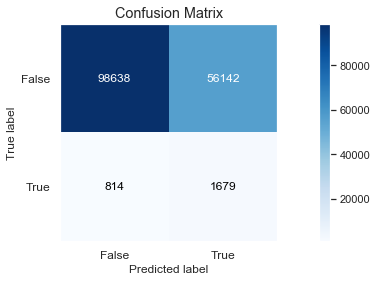

In [140]:
skplt.metrics.plot_confusion_matrix(y_test, predict)

In [105]:
print(accuracy_score(y_test, predict))

0.6379543850501993


### ROC Curve

Text(0.5, 0, 'False positive rate')

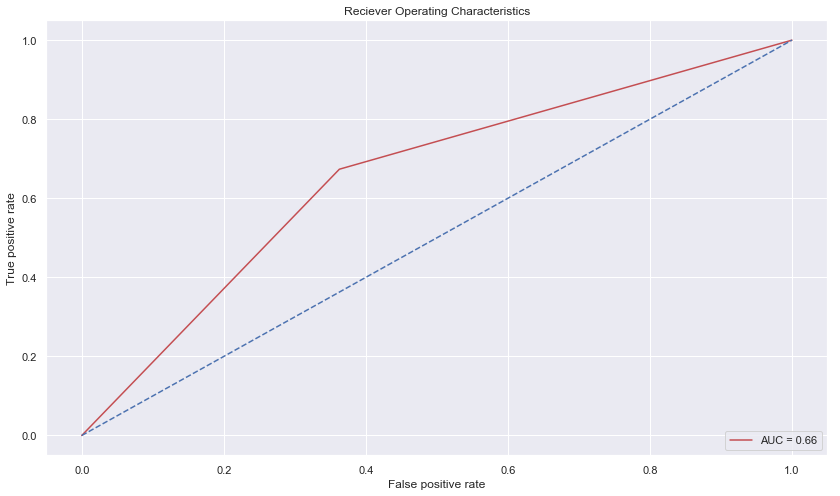

In [141]:
frp,trp, threshold = roc_curve(y_test, predict)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')